In [1]:

# Imports
import sys
import importlib

import pandas as pd
from textblob import TextBlob

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import gc
gc.enable()
gc.collect()

sys.path.append("..")

import StockPrediction.dataset_clean as dh
import helper_funcs as hf
import StockPrediction.sent_models as ml

In [2]:
# Fetch all datasets
news_path = "/../../news_data/"
stock_path = "/../../stock_data/"

news_df, stock_meta = dh.fetch_datasets(news_path, stock_path)
stock_dfs = dh.fetch_stock_data(stock_meta, stock_path)

# Prepare datasets
stock_dfs = dh.prep_stock_data(stock_dfs)
news_df = dh.prep_news_data(news_df, stock_dfs)

# Sentiment Analysis
daily_sent = ml.sentiment_analysis(news_df)

AttributeError: module 'StockPrediction.dataset_clean' has no attribute 'fetch_datasets'

In [3]:
importlib.reload(dh)
importlib.reload(hf)
importlib.reload(ml)

big_df = ml.dataframe_union(stock_dfs, daily_sent)

In [4]:
x_features = ['Open'] + list(news_df['category'].unique())
X = big_df[x_features]

y_0d = big_df['r_0d']
y_1d = big_df['r_1d']
y_7d = big_df['r_7d']
y_30d = big_df['r_30d']

N_EST = 1000
LAMBDA = 0.05
MAX_DEPTH = 6
SUB_SAMP = 0.8
OBJECTIVE = "reg:squarederror"
METHOD = "hist"

In [5]:
# ---- Custom Eval Metrics ----
def mda(y_true, preds):
    return float(np.mean(np.sign(preds) == np.sign(y_true)))

In [6]:
gc.collect()

0

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_0d, test_size=0.2, random_state=42)

model_0d = xgb.XGBRegressor(
    n_estimators = N_EST,
    learning_rate = LAMBDA,
    max_depth = MAX_DEPTH,
    subsample = SUB_SAMP,
    objective = OBJECTIVE,
    tree_method = METHOD,
    eval_metric = ['rmse', mda]
)

model_0d.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

evals_0d = model_0d.evals_result()

model_0d.save_model("xgb_model_0d.json")

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_1d, test_size=0.2, random_state=42)

model_1d = xgb.XGBRegressor(
    n_estimators = N_EST,
    learning_rate = LAMBDA,
    max_depth = MAX_DEPTH,
    subsample = SUB_SAMP,
    objective = OBJECTIVE,
    tree_method = METHOD,
    eval_metric = ['rmse', mda]
)

model_1d.fit(
    X_train, 
    y_train,
    eval_set=[(X_test,y_test)],
    verbose=False
)

evals_1d = model_1d.evals_result()

model_1d.save_model("xgb_model_1d.json")

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y_7d, test_size=0.2, random_state=42)

model_7d = xgb.XGBRegressor(
    n_estimators = N_EST,
    learning_rate = LAMBDA,
    max_depth = MAX_DEPTH,
    subsample = SUB_SAMP,
    objective = OBJECTIVE,
    tree_method = METHOD,
    eval_metric = ['rmse', mda]
)

model_7d.fit(
    X_train, 
    y_train,
    eval_set=[(X_test,y_test)],
    verbose=False
)

evals_7d = model_7d.evals_result()

model_7d.save_model("xgb_model_7d.json")

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_30d, test_size=0.2, random_state=42)

model_30d = xgb.XGBRegressor(
    n_estimators = N_EST,
    learning_rate = LAMBDA,
    max_depth = MAX_DEPTH,
    subsample = SUB_SAMP,
    objective = OBJECTIVE,
    tree_method = METHOD,
    eval_metric = ['rmse', mda]
)

model_30d.fit(
    X_train, 
    y_train,
    eval_set=[(X_test,y_test)],
    verbose=False
)

evals_30d = model_30d.evals_result()

model_30d.save_model("xgb_model_30d.json")

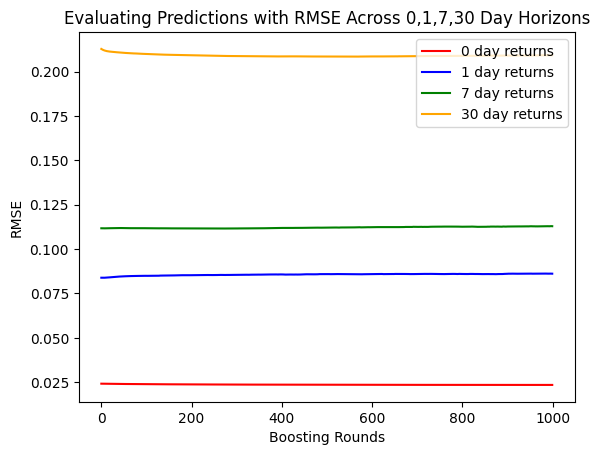

In [11]:
import matplotlib.pyplot as plt

plt.plot(evals_0d['validation_0']['rmse'], color='red', label='0 day returns')
plt.plot(evals_1d['validation_0']['rmse'], color='blue', label='1 day returns')
plt.plot(evals_7d['validation_0']['rmse'], color='green', label='7 day returns')
plt.plot(evals_30d['validation_0']['rmse'], color='orange', label='30 day returns')

plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Evaluating Predictions with RMSE Across 0,1,7,30 Day Horizons')
plt.legend()

plt.show()

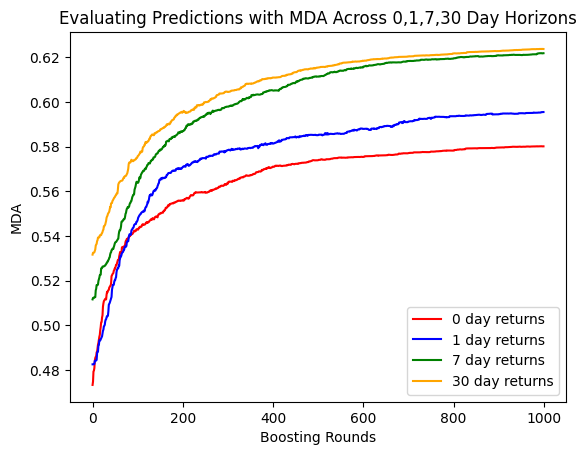

In [12]:
import matplotlib.pyplot as plt

plt.plot(evals_0d['validation_0']['mda'], color='red', label='0 day returns')
plt.plot(evals_1d['validation_0']['mda'], color='blue', label='1 day returns')
plt.plot(evals_7d['validation_0']['mda'], color='green', label='7 day returns')
plt.plot(evals_30d['validation_0']['mda'], color='orange', label='30 day returns')


plt.xlabel('Boosting Rounds')
plt.ylabel('MDA')
plt.title('Evaluating Predictions with MDA Across 0,1,7,30 Day Horizons')
plt.legend()

plt.show()

In [13]:
model0_feat_importance = dict(zip(x_features, model_0d.feature_importances_.tolist()))
model0_sorted = sorted(model0_feat_importance.items(), key=lambda item: item[1], reverse=True)
print(model0_sorted[:5])

[('CULTURE & ARTS', 0.04121524468064308), ('EDUCATION', 0.040833111852407455), ('GOOD NEWS', 0.03947283327579498), ('LATINO VOICES', 0.03778757527470589), ('WEIRD NEWS', 0.03146342560648918)]


In [14]:
model1_feat_importance = dict(zip(x_features, model_1d.feature_importances_.tolist()))
model1_sorted = sorted(model1_feat_importance.items(), key=lambda item: item[1], reverse=True)
print(model1_sorted[:5])

[('EDUCATION', 0.050813887268304825), ('TASTE', 0.050539903342723846), ('BLACK VOICES', 0.04707886278629303), ('ARTS & CULTURE', 0.042741984128952026), ('WORLD NEWS', 0.04119570180773735)]


In [15]:
model7_feat_importance = dict(zip(x_features, model_7d.feature_importances_.tolist()))
model7_sorted = sorted(model7_feat_importance.items(), key=lambda item: item[1], reverse=True)
print(model7_sorted[:5])

[('TASTE', 0.04643937572836876), ('ARTS & CULTURE', 0.04345785081386566), ('PARENTS', 0.04218026623129845), ('QUEER VOICES', 0.03988894447684288), ('WORLD NEWS', 0.039777275174856186)]


In [16]:
model30_feat_importance = dict(zip(x_features, model_30d.feature_importances_.tolist()))
model30_sorted = sorted(model30_feat_importance.items(), key=lambda item: item[1], reverse=True)
print(model30_sorted[:5])

[('TRAVEL', 0.042569421231746674), ('PARENTING', 0.04171070456504822), ('U.S. NEWS', 0.037522222846746445), ('ARTS', 0.036394596099853516), ('WORLDPOST', 0.03178376331925392)]


In [17]:
for i in range(5):
    print(f"Top feature {i+1} for 0d: {model0_sorted[i][0]}, \t1d: {model1_sorted[i][0]}, \t7d: {model7_sorted[i][0]}, \t30d: {model30_sorted[i][0]}")

Top feature 1 for 0d: CULTURE & ARTS, 	1d: EDUCATION, 	7d: TASTE, 	30d: TRAVEL
Top feature 2 for 0d: EDUCATION, 	1d: TASTE, 	7d: ARTS & CULTURE, 	30d: PARENTING
Top feature 3 for 0d: GOOD NEWS, 	1d: BLACK VOICES, 	7d: PARENTS, 	30d: U.S. NEWS
Top feature 4 for 0d: LATINO VOICES, 	1d: ARTS & CULTURE, 	7d: QUEER VOICES, 	30d: ARTS
Top feature 5 for 0d: WEIRD NEWS, 	1d: WORLD NEWS, 	7d: WORLD NEWS, 	30d: WORLDPOST


In [18]:
feat_scores = {}
for feat in x_features:
    feat_scores[feat] = sum([x for x, y in enumerate(model0_sorted + model1_sorted + model7_sorted + model30_sorted) if y[0] == feat])

In [19]:
print(sorted(feat_scores.items(), key=lambda x: x[1], reverse=True)[:5])

[('ENVIRONMENT', 406), ('WELLNESS', 391), ('STYLE & BEAUTY', 388), ('FOOD & DRINK', 386), ('DIVORCE', 386)]


In [20]:
print(big_df.columns)

Index(['Date', 'Ticker', 'Open', 'r_0d', 'r_1d', 'r_7d', 'r_30d', 'SPORTS',
       'SCIENCE', 'COMEDY', 'PARENTING', 'STYLE & BEAUTY', 'WELLNESS',
       'TRAVEL', 'HOME & LIVING', 'QUEER VOICES', 'TECHNOLOGY',
       'CULTURE & ARTS', 'ENTERTAINMENT', 'BUSINESS', 'IMPACT', 'ENVIRONMENT',
       'WEDDINGS', 'BLACK VOICES', 'FOOD & DRINK', 'DIVORCE', 'CRIME', 'MONEY',
       'POLITICS', 'RELIGION', 'ARTS', 'GREEN', 'WORLDPOST', 'STYLE', 'TASTE',
       'PARENTS', 'COLLEGE', 'HEALTHY LIVING', 'WOMEN', 'FIFTY', 'MEDIA',
       'EDUCATION', 'WEIRD NEWS', 'LATINO VOICES', 'GOOD NEWS',
       'ARTS & CULTURE', 'THE WORLDPOST', 'WORLD NEWS', 'U.S. NEWS'],
      dtype='object')


In [4]:
model_0d = xgb.Booster()
model_0d.load_model("xgb_models/xgb_model_0d.json")

In [ ]:
print(model_0d.eval)